In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly_express as px

In [28]:
def generate_hilbert_matrix(n):
    return np.array([[1/(i+j-1) for j in range(1,n +1)] for i in range(1, n+1)])

def numero_condicion(matriz):
    return np.linalg.cond(matriz, p=np.inf)

In [38]:
numeros_condicion = []
rangon = range(2, 20)
for n in rangon:
    A = generate_hilbert_matrix(n)
    datos_simulados = np.random.multivariate_normal(mean=np.zeros(n), cov=A, size=1000)
    cov_sim = np.cov(A)
    condicion = numero_condicion(cov_sim)
    numeros_condicion.append(condicion)

data = {"n": rangon, "condicion": numeros_condicion}
df= pd.DataFrame(data)

fig = px.line(df, x="n", y="condicion", title="condición del numero de la matriz Hilbert vs n")
fig.show()


Cuando se utiliza la matrzi de hilbert para 

In [30]:
H6 = generate_hilbert_matrix(6)
x = np.array([1, 2, 3, 4, 5, 6])
b = np.dot(H6, x)
try:
    x_estimada =  np.linalg.inv(H6) @ b 
    print("Solución estimada:", x_estimada)
except np.linalg.LinAlgError:
    print("No se pudo resolver el sistema debido a la mala condición de H15.")
print("numero de condición en H6: ", numero_condicion(H6))

Solución estimada: [1. 2. 3. 4. 5. 6.]
numero de condición en H6:  29070279.00379062


Aunque para H6 tenemos un resultado optimo con metodos convecionales se observa un numero de condición K alto que obedece a una matriz mal condiconada.

In [31]:

H15 = generate_hilbert_matrix(15)
x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
b = np.dot(H15, x)
try:
    x_estimada =  np.linalg.inv(H15) @ b 
    print("Solución estimada:", x_estimada)
except np.linalg.LinAlgError:
    print("No se pudo resolver el sistema debido a la mala condición de H15.")
print("numero de condición en H15: ",numero_condicion(H15))

Solución estimada: [-4.50581565e+00  2.00421654e+02 -6.07346191e+02  5.78531250e+02
 -1.25225000e+03  4.75100000e+03 -7.84800000e+03  6.35200000e+03
 -2.33600000e+03 -6.40000000e+01  3.84000000e+02 -1.44000000e+02
  5.60000000e+01 -2.00000000e+00  1.92656250e+01]
numero de condición en H15:  1.0417269764903425e+18


Observamos que para H15 con x = H^(-1) * b el numero de condicón es 1.0417269764903425e+18 ya la solución se desborda

In [32]:
try:
    x_estimada2 = np.linalg.solve(H15, b)
    print("Solución estimada:", x_estimada2)
except np.linalg.LinAlgError:
    print("No se pudo resolver el sistema debido a la mala condición de H15.")

Solución estimada: [  0.99999951   2.00007576   2.99712233   4.04722415   4.58549494
   8.14944695   0.18557238  20.63897678  -0.6744124   -2.16371952
  53.6820964  -42.3648982   51.00101332  -0.41395869  17.32996634]


Observamos que para H15 con np.linalg.solve() el numero de condicón es 1.0417269764903425e+18 ya la solución se desborda

Solucionando el problema con Gauss

In [33]:
A = H15
b = b
ab = np.column_stack((A, b))
n = len(b)
for i in range(n):
    pivot = ab[i, i]
    ab[i, :] /= pivot

    for j in range(i + 1, n):
        factor = ab[j, i]
        ab[j, :] -= factor * ab[i, :]

    for j in range(i):
        factor = ab[j, i]
        ab[j, :] -= factor * ab[i, :]

soluciones = ab[:, -1]

print("Soluciones:", soluciones)

Soluciones: [  0.99999973   2.00004501   2.9981313    4.0335111    4.67649769
   7.87639034   0.0844391   24.48663838 -15.70500743  29.97580615
  10.20169506  -4.16879038  29.81491149   6.33950421  16.38622839]


Se identifica que la matriz está mal condicionada ya que tiene un numero de condicion K muy alto de 1.0417269764903425e+18, por lo tanto el resultado convecional utilizando np.linalg.solve() y Gauss-jordan no logran acertar el resultado.



### Regularización


Optimal Alpha: 1e-11
Best Solution: [ 1.00000001  1.99999961  3.0000063   3.99996315  5.00007809  6.00001221
  6.99979568  8.00001555  9.00032194 10.0000564  10.99974054 11.99966437
 13.00017273 14.00046094 14.9997124 ]


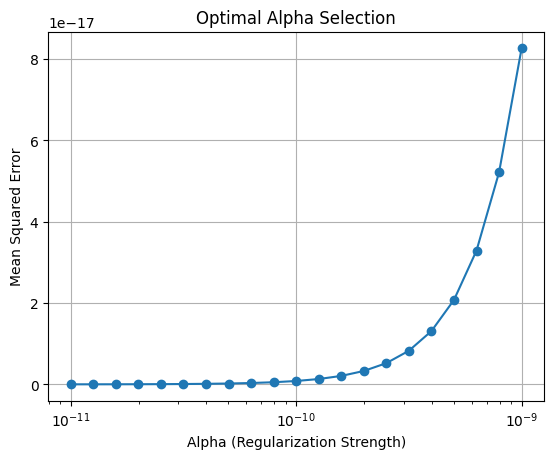

In [45]:
alphas = np.logspace(-11, -9, 21)  # Example alpha values ranging from 1e-10 to 1e10

solutions = []
errors = []

for alpha in alphas:
    ridge = H15 + alpha * np.identity(15)
    try:
        x_estimada = np.linalg.solve(ridge, b)
        solutions.append(x_estimada)
        error = np.mean((np.dot(H15, x_estimada) - b) ** 2)
        errors.append(error)
    except np.linalg.LinAlgError:
        solutions.append(None)
        errors.append(None)

best_alpha_index = np.argmin(errors)
best_alpha = alphas[best_alpha_index]
best_solution = solutions[best_alpha_index]

print("Optimal Alpha:", best_alpha)
print("Best Solution:", best_solution)

plt.figure()
plt.semilogx(alphas, errors, marker='o', linestyle='-')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.title('Optimal Alpha Selection')
plt.grid(True)
plt.show()


In [35]:
alpha = best_alpha
ridge = H15 + alpha * np.identity(15) 
try:
    x_estimada2 = np.linalg.solve(ridge, b)
    print("Solución estimada:", x_estimada2)
except np.linalg.LinAlgError:
    print("No se pudo resolver el sistema debido a la mala condición de H15.")

Solución estimada: [ 0.99999998  2.00000046  3.0000046   3.99990271  5.0004511   5.99933272
  6.99983287  8.00070265  9.00056479  9.99964114 10.99901758 11.9994692
 13.00074607 14.0014011  14.99893234]


Se concluye que al regularizar la matriz de helbert arroja un resultado muy aproximado a la solución esperada.